# K-Anonymity of a numerical quasi-identifier (using a fake dataset)

In [6]:
import pandas as pd
import random

def anonymize_multidim(data, qis, k):
    assert isinstance(data, pd.DataFrame), "Data must be a Pandas dataframe"
    assert isinstance(k, int) and k > 1, "k must be an integer bigger than 1"
    assert all(qi in data.columns for qi in qis), "All QIs must be columns in the data"

    def mondrian(data, qis, k):
        partition = []

        if len(data) <= (2 * k - 1):
            partition.append(data)
            return [data]

        # Select QI to partition
        qi = select_qi_for_partition(data, qis)

        # Sort data by QI
        data = data.sort_values(by=qi)

        # Number of total values
        si = data[qi].count()
        mid = si // 2

        # Split data
        lhs = data[:mid]
        rhs = data[mid:]

        partition.extend(mondrian(lhs, qis, k))
        partition.extend(mondrian(rhs, qis, k))

        return partition
    
    def select_qi_for_partition(data, qis):
        return qis[0]  # Simple example, can be updated

    result_partitions = mondrian(data, qis, k)

    # Anonymize
    result_final = []

    for partition in result_partitions:
        anonymized_partition = partition.copy()
        for qi in qis:
            part_min = partition[qi].min()
            part_max = partition[qi].max()
            anonymized_partition[qi] = f"[{part_min} - {part_max}]"
        result_final.append(anonymized_partition)

    anonymized = pd.concat(result_final)
    
    return anonymized


In [7]:
# Random dataset
ages = [random.randint(21, 68) for _ in range(10_000)]
salaries = [random.randint(2000, 3000) for _ in range(10_000)]
df = pd.DataFrame({'Age': ages, 'Salary': salaries})

In [8]:
columns_to_anonymize = ["Age", "Salary"]

df_anonymized = anonymize_multidim(df, columns_to_anonymize, 200)
print(df.sort_values(by="Age").head(10))
print(df_anonymized.head(10))

      Age  Salary
6658   21    2503
3771   21    2704
765    21    2736
8494   21    2499
5962   21    2575
992    21    2879
8468   21    2896
8462   21    2315
8459   21    2794
8452   21    2762
            Age         Salary
6658  [21 - 22]  [2001 - 3000]
765   [21 - 22]  [2001 - 3000]
8494  [21 - 22]  [2001 - 3000]
5962  [21 - 22]  [2001 - 3000]
992   [21 - 22]  [2001 - 3000]
8468  [21 - 22]  [2001 - 3000]
8462  [21 - 22]  [2001 - 3000]
8459  [21 - 22]  [2001 - 3000]
8452  [21 - 22]  [2001 - 3000]
3252  [21 - 22]  [2001 - 3000]


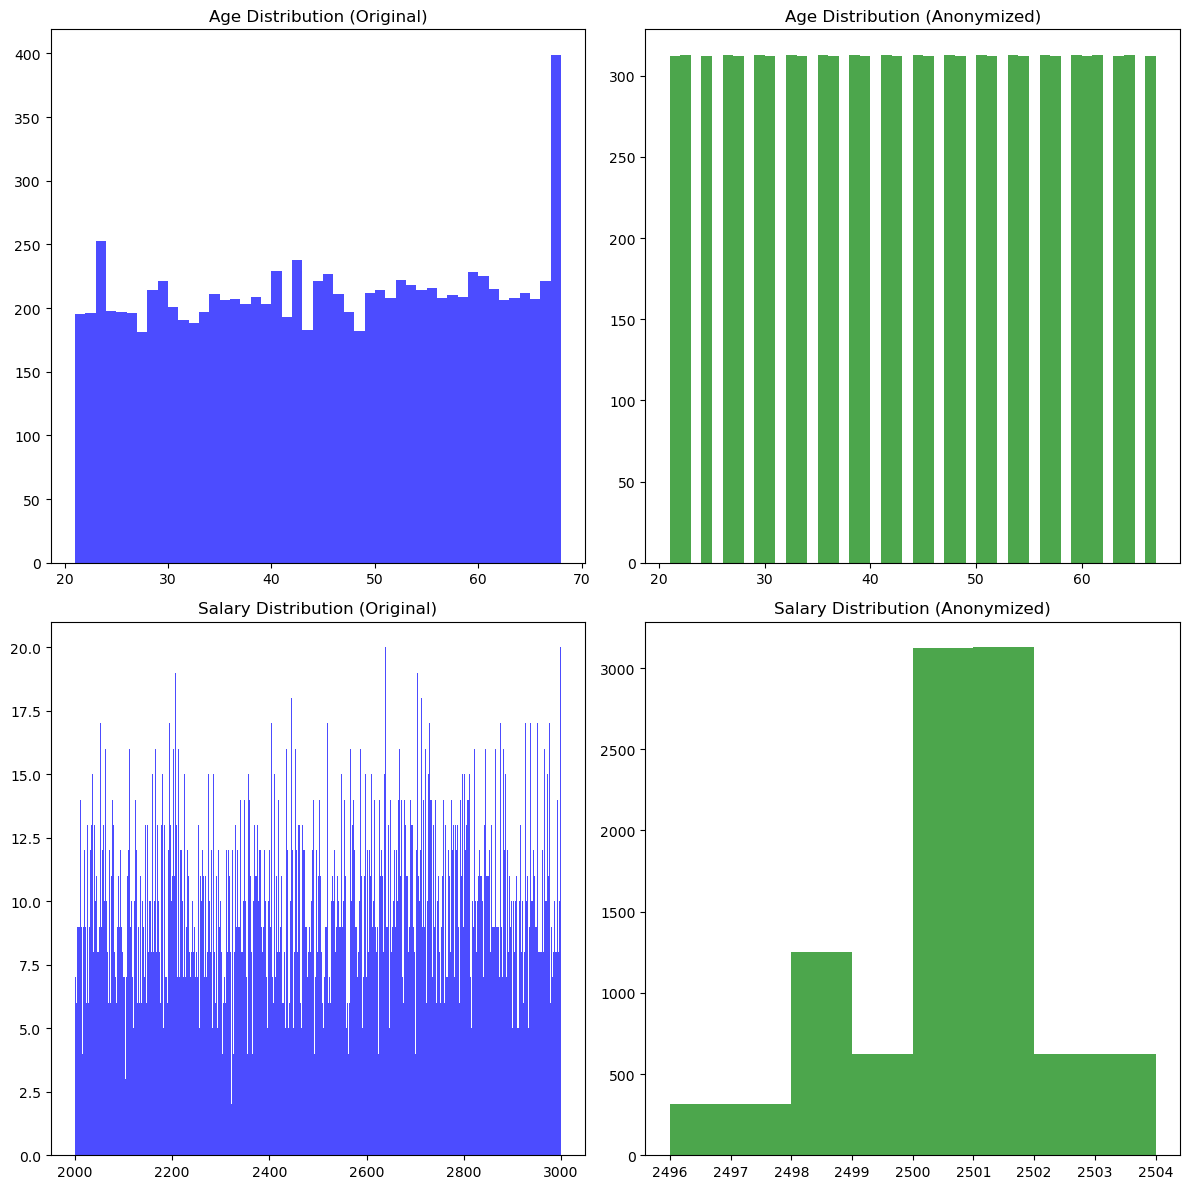

((count    10000.000000
  mean        44.699800
  std         13.818689
  min         21.000000
  25%         33.000000
  50%         45.000000
  75%         57.000000
  max         68.000000
  Name: Age, dtype: float64,
  count    10000.000000
  mean        44.641800
  std         13.784847
  min         21.500000
  25%         33.125000
  50%         44.750000
  75%         56.375000
  max         67.500000
  Name: Age_Midpoint, dtype: float64),
 (count    10000.000000
  mean      2503.641800
  std        288.551235
  min       2000.000000
  25%       2250.000000
  50%       2510.000000
  75%       2751.000000
  max       3000.000000
  Name: Salary, dtype: float64,
  count    10000.000000
  mean      2500.406450
  std          1.543555
  min       2496.500000
  25%       2500.000000
  50%       2500.500000
  75%       2501.500000
  max       2504.000000
  Name: Salary_Midpoint, dtype: float64))

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def extract_midpoint(range_str):
    # Calculate the mean of the range in string format
    return np.mean(list(map(int, range_str.strip('[]').split(' - '))))

# Extract the midpoint for each anonymized column
for column in columns_to_anonymize:
    df_anonymized[f'{column}_Midpoint'] = df_anonymized[column].apply(extract_midpoint)

# Create figures to compare distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Age
axes[0, 0].hist(df['Age'], bins=range(df['Age'].min(), df['Age'].max() + 1), alpha=0.7, color='blue')
axes[0, 0].set_title('Age Distribution (Original)')
axes[0, 1].hist(df_anonymized['Age_Midpoint'], bins=range(int(df_anonymized['Age_Midpoint'].min()), int(df_anonymized['Age_Midpoint'].max()) + 1), alpha=0.7, color='green')
axes[0, 1].set_title('Age Distribution (Anonymized)')

# Salary
axes[1, 0].hist(df['Salary'], bins=range(df['Salary'].min(), df['Salary'].max() + 1), alpha=0.7, color='blue')
axes[1, 0].set_title('Salary Distribution (Original)')
axes[1, 1].hist(df_anonymized['Salary_Midpoint'], bins=range(int(df_anonymized['Salary_Midpoint'].min()), int(df_anonymized['Salary_Midpoint'].max()) + 1), alpha=0.7, color='green')
axes[1, 1].set_title('Salary Distribution (Anonymized)')

plt.tight_layout()
plt.show()

# Calculate and compare summary metrics
summary_original_age = df['Age'].describe()
summary_anonymized_age = df_anonymized['Age_Midpoint'].describe()

summary_original_salary = df['Salary'].describe()
summary_anonymized_salary = df_anonymized['Salary_Midpoint'].describe()

(summary_original_age, summary_anonymized_age), (summary_original_salary, summary_anonymized_salary)


In [5]:
import time

def generate_dataset(num_rows):
    ages = [random.randint(21, 68) for _ in range(num_rows)]
    salaries = [random.randint(2000, 3000) for _ in range(num_rows)]
    return pd.DataFrame({'Age': ages, 'Salary': salaries})

def test_performance(num_rows, k, num_trials):
    total_time = 0
    for _ in range(num_trials):
        df = generate_dataset(num_rows)
        start_time = time.time()
        df_anonymized = anonymize_multidim(df, ["Age", "Salary"], k)
        end_time = time.time()
        total_time += end_time - start_time
    return total_time / num_trials

sizes = [100, 1_000, 10_000, 50_000, 100_000, 500_000, 1_000_000]
k = 5  
num_trials = 5 
average_times = []

for size in sizes:
    avg_elapsed_time = test_performance(size, k, num_trials)
    average_times.append(avg_elapsed_time)
    print(f"Average time for {size} rows over {num_trials} trials: {avg_elapsed_time} seconds")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sizes, average_times, marker='o')
plt.title('Average computing time (seconds) vs TSize of the dataset')
plt.xlabel('Size of the dataset')
plt.ylabel('Average computing time (seconds)')
plt.grid(True)
plt.show()

Average time for 100 rows over 5 trials: 0.015941143035888672 seconds
Average time for 1000 rows over 5 trials: 0.11811013221740722 seconds
Average time for 10000 rows over 5 trials: 1.8356926918029786 seconds


KeyboardInterrupt: 